# <center>LFAToolkit.jl</center>

### <center>Jeremy L Thompson</center>

Local Fourier Analysis Toolkit for analysis and tuning of multigrid and smoothing techniques for finite element operators with arbitrary, user provided weak forms of partial differential equations

<br>
<center>
    <a href="
         https://www.github.com/jeremylt/LFAToolkit.jl">github.com/jeremylt/LFAToolkit.jl</a> 
</center>
<style>
//change background settings {}
div.slide-background {
	border-top: 30px midnightblue solid;
	border-bottom: 30px midnightblue solid;
}
</style>

## <center>Overview</center>

* Introduction
* Mathematical Background
 - Operator Representation
 - Local Fourier Analysis
* PDE Examples
 - Poisson Problem
 - Neo-Hookean Hyperelasticity
* Smoother Examples
 - Jacobi
 - Chebyshev
* Multigrid Examples
 - p-multigrid
 - h-multigrid
* References

## <center>Introduction</center>

Local Fourier Analysis (LFA) of multigrid and preconditioning methods
* models error reduction aross frequencies
* predicts convergence of methods
* facilitates parameter tuning

The technique was first introduced by Brandt in 1977<sup>[2]</sup> for h-multigrid with finite differences

Technique was later adapted for finite elements and additional preconditioning techniues

## <center>Mathematical Background</center>

Mathematical representation of finite element operators and Local Fourier Analysis in LFAToolkit.jl

## <center>Mathematical Background</center>
### <center>Operator Representation</center>

LFAToolkit uses a finite element operator representation to facilitate matrix-free implementations <sup>[3]</sup>

$$
\int_{\Omega} v \cdot f_0 \left( u, \nabla u \right) + \nabla v : f_1 \left( u, \nabla u \right) = \int_{\Omega} f v, \forall v \in V
$$

for some suitable $$V \subseteq H_0^1 \left( \Omega \right)$$

where

* $\cdot$ represents contraction over fields
* $:$ represents contraction over fields and spatial dimensions

## <center>Mathematical Background</center>
### <center>Operator Representation</center>

This weak form can be discretized by selecting a finite element basis

$$
\color{maroon}{\mathbf{A}} u = \sum_e \mathcal{E}^T_e \left[
  \left( \color{royalblue}{\mathbf{B}}_0^e \right)^T \color{royalblue}{\mathbf{W}}^e \Lambda \left( \color{yellowgreen}{\mathbf{f_0}} \left( u^e, \nabla u^e \right) \right)
  + \sum_{i = 1}^d \left( \color{royalblue}{\mathbf{B}}_i^e \right)^T \color{royalblue}{\mathbf{W}}^e \Lambda \left( \color{yellowgreen}{\mathbf{f_1}} \left( u^e, \nabla u^e \right) \right)
\right]
$$

where

<p style="margin-left:10%;">$u^e = \color{royalblue}{\mathbf{B}}_0^e \mathcal{E}^e u$ and $\nabla u^e = \lbrace \color{royalblue}{\mathbf{B}}_i^e \mathcal{E}^e u \rbrace_{i = 1}^d$</p>

## <center>Mathematical Background</center>
### <center>Operator Representation</center>

This operator can be represented as

$$
\color{maroon}{\mathbf{A}} = \mathbf{G}^T \color{royalblue}{\mathbf{B}}^T \color{yellowgreen}{\mathbf{D}} \color{royalblue}{\mathbf{B}} \mathbf{G}
$$

where

* $\color{maroon}{\mathbf{A}}$ - full finite element operator
* $\mathbf{G}$ - element restriction or assembly operator
* $\color{royalblue}{\mathbf{B}}$ - element basis operator (providing $\color{royalblue}{\mathbf{B}}_i$)
* $\color{yellowgreen}{\mathbf{D}}$ - diagonal pointwise weak form operator (from $\color{yellowgreen}{\mathbf{f_0}}$, $\color{yellowgreen}{\mathbf{f_1}}$, and element geometry)

Note: this representation facilitates matrix-free implementation, such as in libCEED<sup>[1]</sup> (<a href="https://github.com/CEED/libCEED">github.com/CEED/libCEED</a>)

## <center>Mathematical Background</center>
### <center>Local Fourier Analysis</center>

LFA investigates the local properties of the descretized operator

Consider a scalar Toeplitz operator $L_h$ on the infinite 1D grid $G_h$

$$
L_h \mathrel{\hat{=}} \left[ s_\kappa \right]_h \left( \kappa \in V \right)
$$
$$
L_h w_h \left( x \right) = \sum_{\kappa \in V} s_\kappa w_h \left( x + \kappa h \right)
$$

where

* $V \subset \mathcal{Z}$ is an index set
* $s_\kappa \in \mathcal{R}$ are constant coefficients
* $w_h \left( x \right)$ is a $l^2$ function on $G_h$

## <center>Mathematical Background</center>
### <center>Local Fourier Analysis</center>

If for all $\varphi \left( \theta, x \right)$

$$
L_h \varphi \left( \theta, x \right) = \tilde{L}_h \left( \theta \right) \varphi \left( \theta, x \right)
$$

then $\tilde{L}_h \left( \theta \right) = \sum_{\kappa \in V} s_\kappa e^{\imath \theta \kappa}$ is the **symbol** of $L_h$

## <center>Mathematical Background</center>
### <center>Local Fourier Analysis</center>

For a system of equations, such as the $p \times p$ linear system of equations representing a scalar problem on a single $p$ order finite element

$$
\tilde{L}_h =
\begin{bmatrix}
    \tilde{L}_h^{1, 1}  &&  \cdots  &&  \tilde{L}_h^{1, p}  \\
    \vdots              &&  \vdots  &&  \vdots              \\
    \tilde{L}_h^{p, 1}  &&  \cdots  &&  \tilde{L}_h^{p, p}  \\
\end{bmatrix}
$$

and multi-component equations are represented in a similar fashion

## <center>Mathematical Background</center>
### <center>Operator Representation + Local Fourier Analysis</center>

We combine these formulations with a localization operator in 1D

$$
\tilde{\color{maroon}{\mathbf{A}}} \left( \mathbf{\theta} \right) = \mathbf{Q}^T \left( \color{maroon}{\mathbf{A}}_e \odot \left[ e^{\imath \left( x_i - x_j \right) \theta / h} \right] \right) \mathbf{Q}
$$

where

* $\color{maroon}{\mathbf{A}}_e = \color{royalblue}{\mathbf{B}}^T \color{yellowgreen}{\mathbf{D}} \color{royalblue}{\mathbf{B}}$
* $\mathbf{Q} = 
\begin{bmatrix}
    I    \\
    e_0  \\
\end{bmatrix} =
\begin{bmatrix}
    1       &&  0       &&  \cdots  &&  0       \\
    0       &&  1       &&  \cdots  &&  0       \\
    \vdots  &&  \vdots  &&  \vdots  &&  \vdots  \\
    0       &&  0       &&  \cdots  &&  1       \\
    1       &&  0       &&  \cdots  &&  0       \\
\end{bmatrix}
$

and higher dimensions are represented with a localization operator formed via tensor products

## <center>PDE Examples</center>

PDEs can be represented in LFAToolkit.jl by providing bases, a mesh, and a pointwise representation of the weak form

## <center>PDE Example</center>
### <center>Poisson Problem</center>

As the classic example, let's look at the scalar Poisson problem

$$
\int \nabla v \nabla u = \int f v
$$

$\color{royalblue}{\mathbf{B}}$ represents the finite element basis, such as a H1 Lagrange basis on Gauss-Lobatto points

$\color{yellowgreen}{\mathbf{D}}$ represents the pointwise application of the weak form

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 2
mesh = Mesh2D(1.0, 1.0) # no distortion

# basis
p = 3
ncomp = 1
# - order p element with p+1 quad pts and 1 component in 2d
basis = TensorH1LagrangeBasis(p, p+1, ncomp, dim)

# weak form
function diffusionweakform(du::Array{Float64}, w::Array{Float64})
    dv = du*w[1]
    return dv
end

# operator
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
]
outputs = [OperatorField(basis, [EvaluationMode.gradient])]
A = Operator(diffusionweakform, mesh, inputs, outputs)

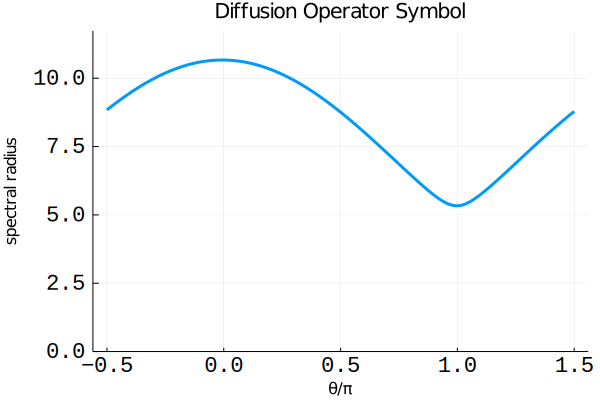

In [1]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# compute full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # compute
    maxeigenvalues = zeros(numberruns)

    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        A = computesymbols(diffusion, θ)
        eigenvalues = [abs(val) for val in eigvals(A)]
        maxeigenvalues[i] = max(eigenvalues...)
        maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Diffusion Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # compute
    maxeigenvalues = zeros(numberruns, numberruns)

    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        A = computesymbols(diffusion, θ)
        eigenvalues = [abs(val) for val in eigvals(A)]
        maxeigenvalues[i, j] = max(eigenvalues...)
        maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        title="Diffusion Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

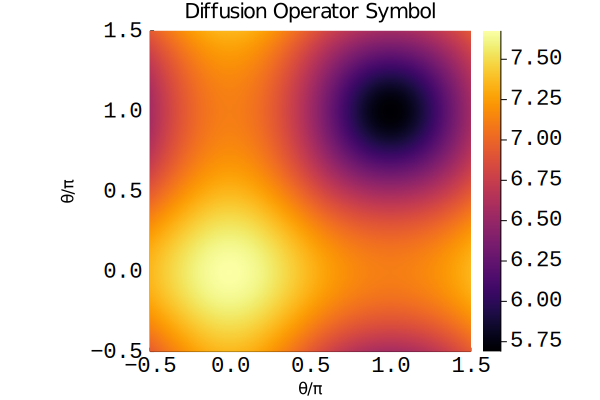

In [2]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# compute full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # compute
    maxeigenvalues = zeros(numberruns)

    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        A = computesymbols(diffusion, θ)
        eigenvalues = [abs(val) for val in eigvals(A)]
        maxeigenvalues[i] = max(eigenvalues...)
        maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Diffusion Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # compute
    maxeigenvalues = zeros(numberruns, numberruns)

    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        A = computesymbols(diffusion, θ)
        eigenvalues = [abs(val) for val in eigvals(A)]
        maxeigenvalues[i, j] = max(eigenvalues...)
        maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        title="Diffusion Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>PDE Example</center>
### <center>Neo-Hookean Hyperelasticity</center>

And for something more complex, the Neo-Hookean hyperelasticity problem

The strong form of the static balance of linear-momentum at finite strain is given by

$$
-\nabla_x \cdot \mathbf{P} - \rho_0 \mathbf{g} = \mathbf{0}
$$

where $-\nabla_k$ is the gradient with respect to the reference configuration, $\mathbf{P}$ is the first Piola-Kirchhoff stress tensor, $\rho_0$ is the reference mass density, and $\mathbf{g}$ is the forcing function.

The first Piola-Kirchhoff stress tensor is given by

$$
\mathbf{P} = \mathbf{F} \mathbf{S}
$$

where $\mathbf{F}$ is the deformation gradient and $\mathbf{S}$ is the second Piola-Kirchhoff stress tensor

In [ ]:
# setup
using LFAToolkit
using LinearAlgebra

dim = 3
mesh = Mesh3D(1.0, 1.0, 1.0)
p = 3
ncomp = 1
basis = TensorH1LagrangeBasis(p, p+1, ncomp, dim)

# constants
e = 1E6                     # Young's modulus
ν = 0.3                     # Poisson's ratio
K = e/(3*(1 - 2*ν))         # bulk modulus
λ = e*ν/((1 + ν)*(1 - 2*ν)) # Lamé parameters
μ = e/(2*(1 + ν))

# state
gradu = [1; 2; 3]*ones(1, 3);

function neohookeanweakform(deltadu::Array{Float64}, w::Array{Float64})
    # dP = dF S + F dS

    # deformation gradient
    F = gradu + I
    J = det(F)
    # Green-Lagrange strain tensor
    E = (gradu*gradu' + gradu'*gradu)/2
    # right Cauchy-Green tensor
    C = 2*E + I
    C_inv = C^-1
    # second Piola-Kirchhoff
    S = λ*log(J)*C_inv + 2*μ*C_inv*E

    # delta du
    deltadu = deltadu'
    # dF
    dF = deltadu + I
    # deltaE
    deltaE = (deltadu*deltadu' + deltadu'*deltadu)/2
    # dS
    dS = λ*sum(C_inv.*deltaE)*C_inv + 2*(μ - λ*log(J))*C_inv*deltaE*C_inv
    # dP
    dP = dF*S + F*dS

    return [dP']
end

# linearized Neo-Hookean operator
inputs = [
    OperatorField(basis, [EvaluationMode.gradient], "gradent of deformation"),
    OperatorField(basis, [EvaluationMode.quadratureweights], "quadrature weights"),
]
outputs = [
    OperatorField(
        basis,
        [EvaluationMode.gradient],
        "test function gradient of deformation",
    ),
]
A = Operator(neohookeanweakform, mesh, inputs, outputs)

## <center>Smoother Examples</center>

The error propegation operator for smoothers is given by

$$
\mathbf{S} = \mathbf{I} - \mathbf{M}^{-1} \color{maroon}{\mathbf{A}}
$$

where $\mathbf{M}^{-1}$ is the smoothing operator

## <center>Smoother Example</center>
### <center>Jacobi</center>

Lets consider simple Jacobi smoothing

$$
\mathbf{M}^{-1} = \omega \space \text{diag} \left( \color{maroon}{\mathbf{A}} \right)^{-1}
$$

The error propegation **symbol** is given by

$$
\tilde{\mathbf{S}} \left( \omega, \mathbf{\theta} \right) = \mathbf{I} - \omega \space \text{diag} \left( 
\tilde{\color{maroon}{\mathbf{A}}} \right) \tilde{\color{maroon}{\mathbf{A}}} \left( \mathbf{\theta} \right)
$$

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 2
mesh = Mesh2D(1.0, 1.0)

# operator
A = GalleryOperator("diffusion", p, p+1, mesh)
S = Jacobi(A)

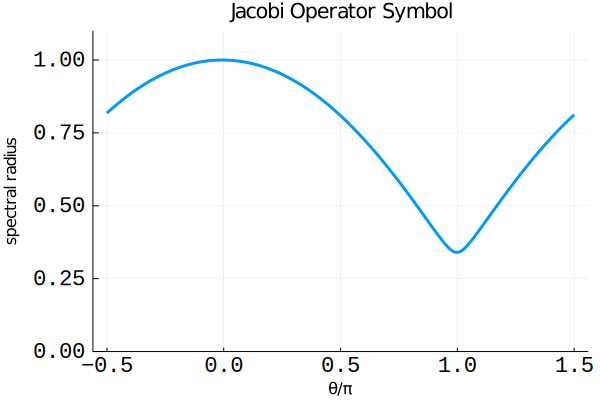

In [3]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# Jacobi smoother
jacobi = Jacobi(diffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [0.77]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1] % 2π) >  π/256
            A = computesymbols(jacobi, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Jacobi Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [1.0]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(jacobi, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="Jacobi Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

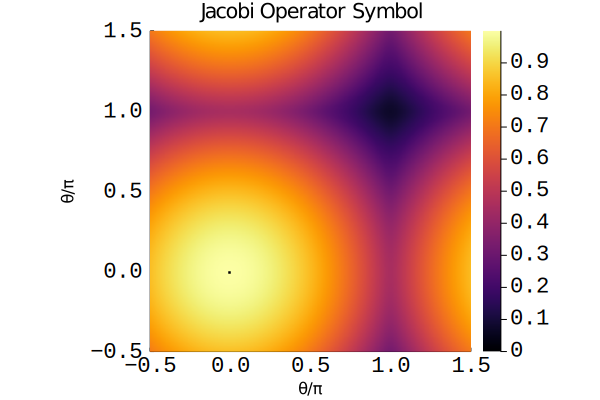

In [4]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# Jacobi smoother
jacobi = Jacobi(diffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [1.0]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1] % 2π) >  π/128
            A = computesymbols(jacobi, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Jacobi Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [1.0]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(jacobi, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="Jacobi Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Smoother Example</center>
### <center>Chebyshev</center>

Lets consider Chebyshev polynomial smoothing

$$
\mathbf{M}^{-1} = \rho_q \left( \text{diag} \left( \color{maroon}{\mathbf{A}} \right)^{-1} \color{maroon}{\mathbf{A}} \right)
$$

where

$\rho$ is derived from the Chebyshev polynomials<sup>[4]</sup> and $q$ is the polynomial order of the smoother

The error propegation **symbol** is given by

$$
\tilde{\mathbf{S}} \left( q, \mathbf{\theta} \right) = \mathbf{I} - \rho_q \left( \text{diag} \left( \tilde{\color{maroon}{\mathbf{A}}} \right)^{-1} \tilde{\color{maroon}{\mathbf{A}}} \left( \mathbf{\theta} \right) \right) \tilde{\color{maroon}{\mathbf{A}}} \left( \mathbf{\theta} \right)
$$

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 2
mesh = Mesh2D(1.0, 1.0)

# operator
A = GalleryOperator("diffusion", p, p+1, mesh)
S = Chebyshev(A)

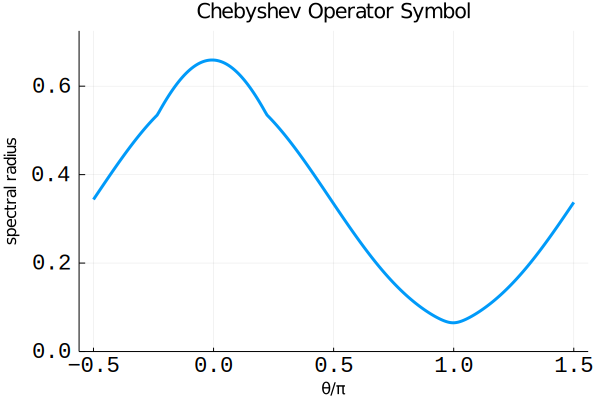

In [5]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# Chebyshev smoother
chebyshev = Chebyshev(diffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1] % 2π) >  π/256
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Chebyshev Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="Chebyshev Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

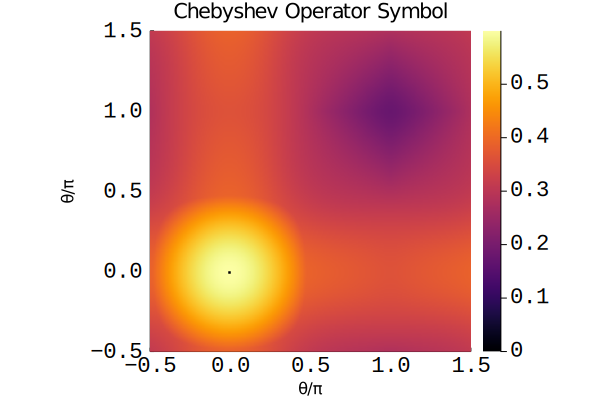

In [6]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
p = 3
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

# operator
diffusion = GalleryOperator("diffusion", p, p, mesh)

# Chebyshev smoother
chebyshev = Chebyshev(diffusion)

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1] % 2π) >  π/128
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="Chebyshev Operator Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(chebyshev, ω, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="Chebyshev Operator Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Multigrid Examples</center>

The error propegation of a multigrid method is given by

$$
\mathbf{M}_{TMG} = \mathbf{S}_f \left( \mathbf{I} - \mathbf{P}_{ctof} \color{maroon}{\mathbf{A}}_c^{-1} \mathbf{R}_{ftoc} \color{maroon}{\mathbf{A}}_f \right) \mathbf{S}_f
$$

where the grid transfer opertors $\mathbf{P}_{ctof}$ and $\mathbf{R}_{ftoc}$ determine the type of multigrid method

## <center>Multigrid Example</center>
### <center>P-Multigrid</center>

P-type multigrid coarsens by reducing the order of the finite element bases

$$
\mathbf{P}_{ctof} = \mathbf{P}_f^T \mathbf{P}_e \mathbf{P}_c\\
\mathbf{P}_e = \color{yellowgreen}{\mathbf{D}}_{scale} \color{royalblue}{\mathbf{B}}_{ctof}
$$

Multigrid prolongation is given by interpolating low order basis functions to high order basis nodes

$$
\mathbf{R}_{ctof} = \mathbf{P}_{ctof}^T
$$

Multigrid restriction is given by the transpose of multigrid prolongation

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 2
mesh = Mesh2D(1.0, 1.0)

# bases
finep = 3
coarsep = 2
ncomp = 1
ctofbasis = TensorH1LagrangeBasis(coarsep, finep, ncomp, dim, lagrangequadrature = true)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Chebyshev smoother
S = Chebyshev(finediffusion)

# p-multigrid preconditioner
M = PMultigrid(finediffusion, coarsediffusion, S, [ctofbasis])

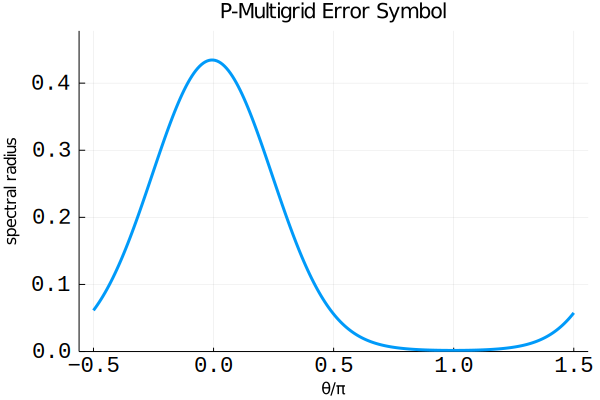

In [7]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
finep = 3
coarsep = 2
numbercomponents = 1
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangePProlongationBasis(coarsep, finep, numbercomponents, dimension)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="P-Multigrid Error Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="P-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

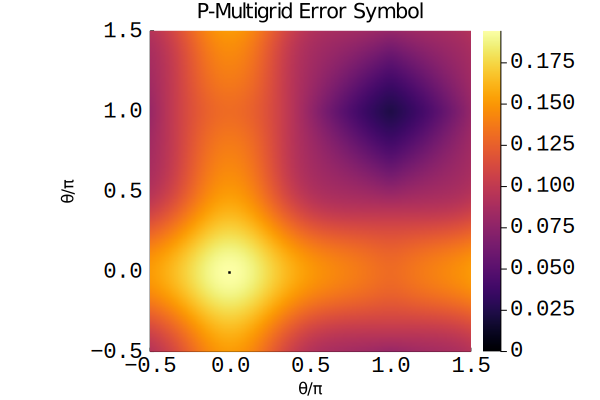

In [8]:
using LFAToolkit
using LinearAlgebra
using Plots

# setup
finep = 3
coarsep = 2
numbercomponents = 1
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

ctofbasis = TensorH1LagrangePProlongationBasis(coarsep, finep, numbercomponents, dimension)

# diffusion operators
finediffusion = GalleryOperator("diffusion", finep, finep, mesh)
coarsediffusion = GalleryOperator("diffusion", coarsep, finep, mesh)

# Jacobi smoother
chebyshev = Chebyshev(finediffusion)

# p-multigrid preconditioner
multigrid = PMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="P-Multigrid Error Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="P-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Multigrid Example</center>
### <center>H-Multigrid</center>

H-type multigrid coarsens by combining finite elements to produce a coarser mesh

H-multigrid prolongation is interpolation from a single element to a *macro-element*

$$
\mathbf{R}_{ctof} = \mathbf{P}_{ctof}^T
$$

Restriction is, again, given by the transpose operation

In [ ]:
# setup
using LFAToolkit

# mesh
dim = 2
mesh = Mesh2D(1.0, 1.0)

# operators
function diffusionweakform(du::Array{Float64}, w::Array{Float64})
    dv = du*w[1]
    return [dv]
end
# -- fine
ncomp = 1
numelemfine1d = 2
basis = TensorH1LagrangeMacroBasis(p, p+1, ncomp, dim, numelemfine1d);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
finediffusion = Operator(diffusionweakform, mesh, inputs, outputs);
# -- coarse
basis = TensorH1LagrangeBasis(p, p+1, ncomp, dim);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
coarsediffusion = Operator(diffusionweakform, mesh, inputs, outputs);

# Chebyshev smoother
S = Chebyshev(finediffusion)

# h-multigrid preconditioner
M = HMultigrid(finediffusion, coarsediffusion, S, [ctofbasis])

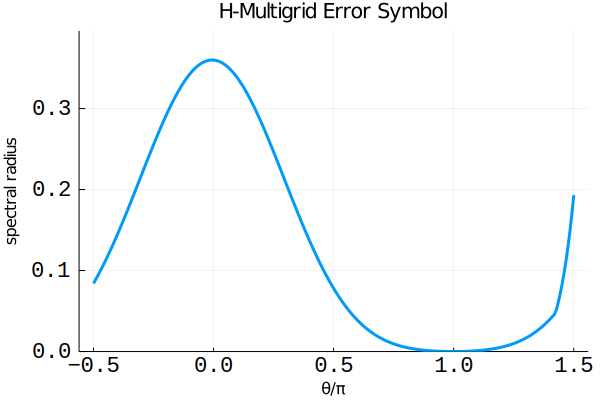

In [9]:
using LFAToolkit
using LinearAlgebra
using Plots

#setup
p = 2
numbercomponents = 1
dimension = 1

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

numberfineelements1d = 2
ctofbasis = TensorH1LagrangeHProlongationBasis(p, numbercomponents, dimension, numberfineelements1d);

# operators
function diffusionweakform(du::Array{Float64}, w::Array{Float64})
    dv = du*w[1]
    return [dv]
end
# -- fine
basis = TensorH1LagrangeMacroBasis(p, p + 1, numbercomponents, dimension, numberfineelements1d);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
finediffusion = Operator(diffusionweakform, mesh, inputs, outputs);
# -- coarse
basis = TensorH1LagrangeBasis(p, p + 1, numbercomponents, dimension);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
coarsediffusion = Operator(diffusionweakform, mesh, inputs, outputs);

# Chebyshev smoother
chebyshev = Chebyshev(finediffusion)

# h-multigrid preconditioner
multigrid = HMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -1π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/256
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="H-Multigrid Error Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="H-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

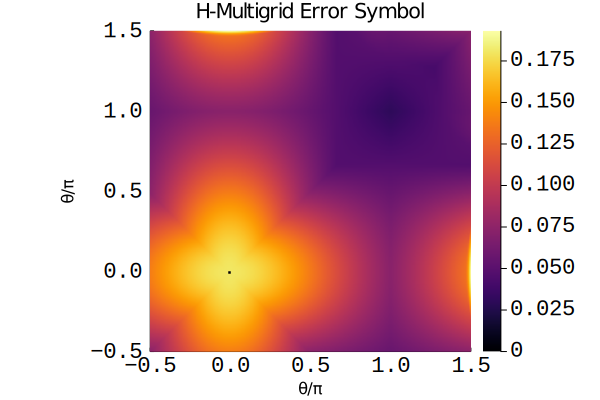

In [10]:
using LFAToolkit
using LinearAlgebra
using Plots

#setup
p = 2
numbercomponents = 1
dimension = 2

mesh = []
if dimension == 1
   mesh = Mesh1D(1.0)
elseif dimension == 2
   mesh = Mesh2D(1.0, 1.0)
end

numberfineelements1d = 2
ctofbasis = TensorH1LagrangeHProlongationBasis(p, numbercomponents, dimension, numberfineelements1d);

# operators
function diffusionweakform(du::Array{Float64}, w::Array{Float64})
    dv = du*w[1]
    return [dv]
end
# -- fine
basis = TensorH1LagrangeMacroBasis(p, p + 1, numbercomponents, dimension, numberfineelements1d);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
finediffusion = Operator(diffusionweakform, mesh, inputs, outputs);
# -- coarse
basis = TensorH1LagrangeBasis(p, p + 1, numbercomponents, dimension);
inputs = [
    OperatorField(basis, [EvaluationMode.gradient]),
    OperatorField(basis, [EvaluationMode.quadratureweights]),
];
outputs = [OperatorField(basis, [EvaluationMode.gradient])];
coarsediffusion = Operator(diffusionweakform, mesh, inputs, outputs);

# Chebyshev smoother
chebyshev = Chebyshev(finediffusion)

# h-multigrid preconditioner
multigrid = HMultigrid(finediffusion, coarsediffusion, chebyshev, [ctofbasis])

# full operator symbols
numberruns = 250
maxeigenvalue = 0
θ_min = -1π/2
θ_max = 3π/2

# compute and plot smoothing factor
# -- 1D --
if dimension == 1
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns)

    # compute
    for i in 1:numberruns
        θ = [θ_min + (θ_max - θ_min)*i/numberruns]
        if abs(θ[1]  % 2π) >  π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    plot(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        maxeigenvalues,
        ytickfont=font(12, "Courier"),
        ylabel="spectral radius",
        linewidth=3,
        legend=:none,
        title="H-Multigrid Error Symbol"
    )
    ylims!(0.0, max(maxeigenvalues...) * 1.1)
# -- 2D --
elseif dimension == 2
    # setup
    ω = [3]
    v = [1, 1]
    maxeigenvalues = zeros(numberruns, numberruns)

    # compute
    for i in 1:numberruns, j in 1:numberruns
        θ = [
            θ_min + (θ_max - θ_min)*i/numberruns,
            θ_min + (θ_max - θ_min)*j/numberruns
        ]
        if sqrt(abs(θ[1] % 2π)^2 + abs(θ[2] % 2π)^2) > π/128
            A = computesymbols(multigrid, ω, v, θ)
            eigenvalues = [abs(val) for val in eigvals(A)]
            maxeigenvalues[i, j] = max(eigenvalues...)
            maxeigenvalue = max(maxeigenvalue, maxeigenvalues[i, j])
        end
    end

    # plot
    #println("max eigenvalue: ", maxeigenvalue)
    xrange = θ_min/π:(θ_max - θ_min)/π/(numberruns-1):θ_max/π
    heatmap(
        xrange,
        xlabel="θ/π",
        xtickfont=font(12, "Courier"),
        xrange,
        ylabel="θ/π",
        ytickfont=font(12, "Courier"),
        maxeigenvalues,
        title="H-Multigrid Error Symbol",
        transpose=true,
        aspect_ratio=:equal
    )
    xlims!(θ_min/π, θ_max/π)
    ylims!(θ_min/π, θ_max/π)
end

## <center>Questions?</center>

<center>
<a href="https://www.github.com/jeremylt">github.com/jeremylt</a>
<br>
<a href="https://www.github.com/jeremylt/LFAToolkit.jl">github.com/jeremylt/LFAToolkit.jl</a>
</center>

## <center>References</center>

[1] A. Abdelfattah, V. Barra, N. Beams, J. Brown, J.S. Camier,V. Dobrev, Y. Dudouit,L. Ghaffari, T. Kolev, D. Medina, T. Rathnayake, J. L. Thompson,  and S. Tomov, *libCEED User Manual*, Zenodo (2020), https://doi.org/10.5281/zenodo.4302737.

[2] A. Brandt, *Multi-level adaptive solutions to boundary-value problems*, Math. Comp., 31(138) (1977), pp. 33-390.

[3] J. Brown, *Efficient nonlinear solvers for nodal high-order finite elements in 3D*, Journal of Scientific Computing, 45 (2010), pp. 48-63.

[4] M. Gutknecht and S. Röllin,  *The Chebyshev iteration revisited*, Parallel Computing, 28 (2002), pp. 263-283.